In [1]:
from pm4py import read_bpmn, view_bpmn, view_petri_net
import json

In [2]:
bp_ex = read_bpmn("running_example_annotated.bpmn")

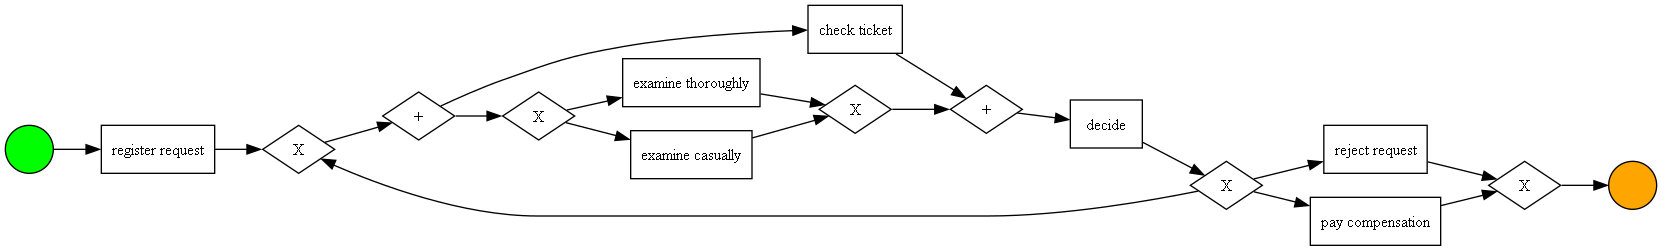

In [3]:
view_bpmn(bp_ex)

In [4]:
import uuid
from enum import Enum

from pm4py.objects.petri_net.utils import reduction
from pm4py.objects.petri_net.obj import PetriNet, Marking
from pm4py.objects.petri_net.utils.petri_utils import add_arc_from_to
from pm4py.util import exec_utils

class Parameters(Enum):
    USE_ID = "use_id"
    ENABLE_REDUCTION = "enable_reduction"
    RETURN_FLOW_TRANS_MAP = "return_flow_trans_map"



In [5]:
def convert_to_petri_net_apply(bpmn_graph, parameters=None):

    #BCS
    spec_nodes = {}
    
    if parameters is None:
        parameters = {}

    import networkx as nx
    from pm4py.objects.bpmn.obj import BPMN

    use_id = exec_utils.get_param_value(Parameters.USE_ID, parameters, False)
    return_flow_trans_map = exec_utils.get_param_value(Parameters.RETURN_FLOW_TRANS_MAP, parameters, False)
    enable_reduction = exec_utils.get_param_value(Parameters.ENABLE_REDUCTION, parameters, True)

    if return_flow_trans_map:
        enable_reduction = False

    net = PetriNet("")
    source_place = PetriNet.Place("source")
    net.places.add(source_place)
    sink_place = PetriNet.Place("sink")
    net.places.add(sink_place)
    im = Marking()
    fm = Marking()
    im[source_place] = 1
    fm[sink_place] = 1

    # keep this correspondence for adding invisible transitions for OR-gateways
    inclusive_gateway_exit = set()
    inclusive_gateway_entry = set()

    flow_place = {}
    source_count = {}
    target_count = {}
    for flow in bpmn_graph.get_flows():
        source = flow.get_source()
        target = flow.get_target()
        place = PetriNet.Place(str(flow.get_id()))
        net.places.add(place)
        flow_place[flow] = place
        if source not in source_count:
            source_count[source] = 0
        if target not in target_count:
            target_count[target] = 0
        source_count[source] = source_count[source] + 1
        target_count[target] = target_count[target] + 1

    for flow in bpmn_graph.get_flows():
        source = flow.get_source()
        target = flow.get_target()
        place = PetriNet.Place(str(flow.get_id()))
        if isinstance(source, BPMN.InclusiveGateway) and source_count[source] > 1:
            inclusive_gateway_exit.add(place.name)
        elif isinstance(target, BPMN.InclusiveGateway) and target_count[target] > 1:
            inclusive_gateway_entry.add(place.name)

    # remove possible places that are both in inclusive_gateway_exit and inclusive_gateway_entry,
    # because we do not need to add invisibles in this situation
    incl_gat_set_inters = inclusive_gateway_entry.intersection(inclusive_gateway_exit)
    inclusive_gateway_exit = inclusive_gateway_exit.difference(incl_gat_set_inters)
    inclusive_gateway_entry = inclusive_gateway_entry.difference(incl_gat_set_inters)

    nodes_entering = {}
    nodes_exiting = {}
    trans_map = {}

    for node in bpmn_graph.get_nodes():
        entry_place = PetriNet.Place("ent_" + str(node.get_id()))
        net.places.add(entry_place)
        exiting_place = PetriNet.Place("exi_" + str(node.get_id()))
        net.places.add(exiting_place)
        if use_id:
            label = str(node.get_id())
        else:
            label = str(node.get_name()) if isinstance(node, BPMN.Task) else None
            if not label:
                label = None
        transition = PetriNet.Transition(name=str(node.get_id()), label=label)
        net.transitions.add(transition)
        trans_map[node] = [transition]
        add_arc_from_to(entry_place, transition, net)
        add_arc_from_to(transition, exiting_place, net)
        
        #BCS
        print(label)
        if label is not None and label.split(' ')[0] == 'examine':
            print('Spec')
            extending_place = PetriNet.Place("ext_" + str(node.get_id()))
            net.places.add(extending_place)
            add_arc_from_to(extending_place, transition, net)
            add_arc_from_to(transition, extending_place, net)
            print(extending_place)
            im[extending_place] = 1
            fm[extending_place] = 1

        if isinstance(node, BPMN.ParallelGateway) or isinstance(node, BPMN.InclusiveGateway):
            if source_count[node] > 1:
                exiting_object = PetriNet.Transition(str(uuid.uuid4()), None)
                net.transitions.add(exiting_object)
                add_arc_from_to(exiting_place, exiting_object, net)
                trans_map[node].append(exiting_object)
            else:
                exiting_object = exiting_place

            if target_count[node] > 1:
                entering_object = PetriNet.Transition(str(uuid.uuid4()), None)
                net.transitions.add(entering_object)
                add_arc_from_to(entering_object, entry_place, net)
                trans_map[node].append(entering_object)
            else:
                entering_object = entry_place
            nodes_entering[node] = entering_object
            nodes_exiting[node] = exiting_object
        else:
            nodes_entering[node] = entry_place
            nodes_exiting[node] = exiting_place

        if isinstance(node, BPMN.StartEvent):
            start_transition = PetriNet.Transition(str(uuid.uuid4()), None)
            net.transitions.add(start_transition)
            add_arc_from_to(source_place, start_transition, net)
            add_arc_from_to(start_transition, entry_place, net)
            trans_map[node].append(start_transition)
        elif isinstance(node, BPMN.EndEvent):
            end_transition = PetriNet.Transition(str(uuid.uuid4()), None)
            net.transitions.add(end_transition)
            add_arc_from_to(exiting_place, end_transition, net)
            add_arc_from_to(end_transition, sink_place, net)
            trans_map[node].append(end_transition)

    for flow in bpmn_graph.get_flows():
        source_object = nodes_exiting[flow.get_source()]
        target_object = nodes_entering[flow.get_target()]

        if isinstance(source_object, PetriNet.Place):
            inv1 = PetriNet.Transition(f"sfl_{flow.get_id()}", None)
            net.transitions.add(inv1)
            add_arc_from_to(source_object, inv1, net)
            source_object = inv1
            trans_map[flow.source].append(inv1)

        if isinstance(target_object, PetriNet.Place):
            inv2 = PetriNet.Transition(f"tfl_{flow.get_id()}", None)
            net.transitions.add(inv2)
            add_arc_from_to(inv2, target_object, net)
            target_object = inv2
            trans_map[flow.target].append(inv2)

        add_arc_from_to(source_object, flow_place[flow], net)
        add_arc_from_to(flow_place[flow], target_object, net)

    if inclusive_gateway_exit and inclusive_gateway_entry:
        # do the following steps if there are inclusive gateways:
        # - calculate the shortest paths
        # - add an invisible transition between couples of corresponding places
        # this ensures soundness and the correct translation of the BPMN
        inv_places = {x.name: x for x in net.places}
        digraph = build_digraph_from_petri_net(net)
        all_shortest_paths = dict(nx.all_pairs_dijkstra(digraph))
        keys = list(all_shortest_paths.keys())

        for pl1 in inclusive_gateway_exit:
            if pl1 in keys:
                output_places = sorted(
                    [(x, len(y)) for x, y in all_shortest_paths[pl1][1].items() if x in inclusive_gateway_entry],
                    key=lambda x: x[1])
                if output_places:
                    inv_trans = PetriNet.Transition(str(uuid.uuid4()), None)
                    net.transitions.add(inv_trans)
                    add_arc_from_to(inv_places[pl1], inv_trans, net)
                    add_arc_from_to(inv_trans, inv_places[output_places[0][0]], net)

    if enable_reduction:
        reduction.apply_simple_reduction(net)

    if return_flow_trans_map:
        return net, im, fm, flow_place, trans_map

    return net, im, fm

In [6]:
pn, i, f = convert_to_petri_net_apply(bp_ex)

check ticket
examine casually
Spec
ext_Activity_114fwgn
None
pay compensation
decide
None
None
register request
None
None
examine thoroughly
Spec
ext_Activity_1rpdqbz
None
None
reject request
None
None


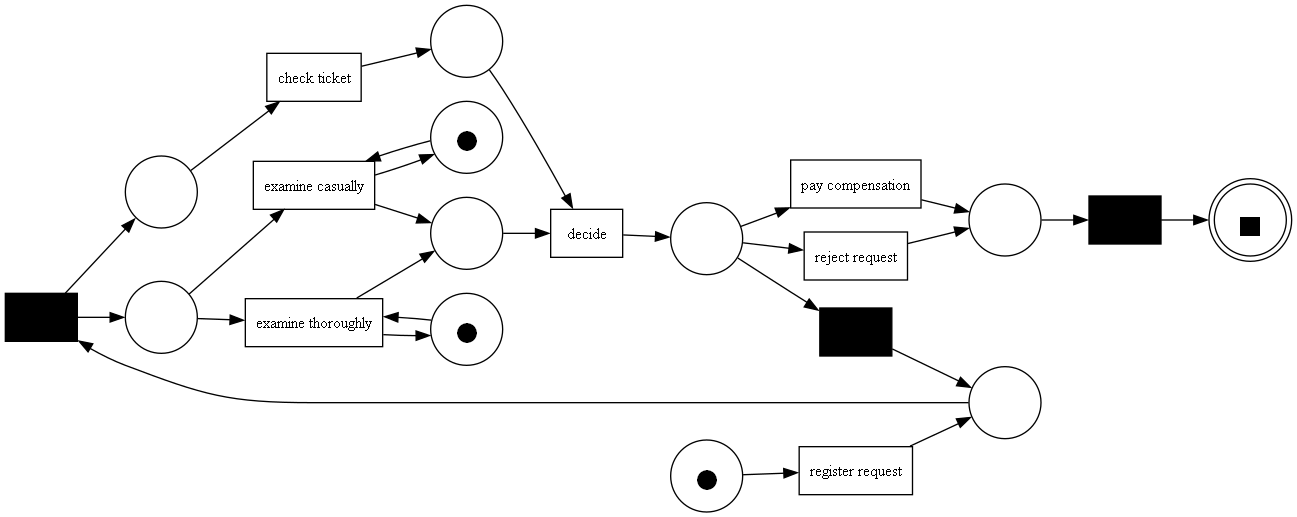

In [7]:
view_petri_net(pn, i, f)

In [8]:
from pm4py import read_xes, fitness_token_based_replay

In [9]:
type(i)

pm4py.objects.petri_net.obj.Marking

In [10]:
log = read_xes('running-example.xes')
fitness = fitness_token_based_replay(log, pn, i, f)
fitness

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\pm4py\util\dt_parsing\parser.py:76: UserWarning: ISO8601 strings are not fully supported with strpfromiso for Python versions below 3.11
  warnings.warn(


parsing log, completed traces ::   0%|          | 0/6 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/6 [00:00<?, ?it/s]

{'perc_fit_traces': 100.0,
 'average_trace_fitness': 1.0,
 'log_fitness': 1.0,
 'percentage_of_fitting_traces': 100.0}